French Gender predictor 
- uses the Lexique dictionary 
- currently uses LSTM model


In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.2.0


In [2]:
#import the libraries we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [4]:
#load data from lexique.com - filtered to leave only singular nouns & irrelevant columns have been removed to leave just noun and gender
#ONLY NEED TO RUN THIS IF THE FILE IS NOT ON THE GOOGLE DRIVE
from google.colab import files
import io

uploaded = files.upload() # run this first time to upload the data to google drive


Saving FrenchNouns.csv to FrenchNouns.csv


In [5]:
df = pd.read_csv('FrenchNouns.csv') #encoding='ISO-8859-1')
#df.head()

In [6]:
# create binary labels
df['b_labels'] = df['Gender'].map({'m': 0, 'f': 1})
Y = df['b_labels'].values
#df.head()

In [9]:
# split up the data into training and test sets

df_train, df_test, Ytrain, Ytest = train_test_split(df['Noun'], Y, test_size=0.60)

In [10]:
print(df_train.shape, df_test.shape, Ytrain.shape, Ytest.shape)


(10854,) (16282,) (10854,) (16282,)


In [11]:
# Convert words to sequences of letters

def is_nan(x):  # needed to clean a bad line of input
    return (x is np.nan or x != x)
    
letters_train = []
letters_test  = []

for i in range(0,len(df_train)):
  if is_nan(df_train.iloc[i]):
    letters_train.append(' ')
  else:
    letters_train.append(list(df_train.iloc[i]))

for i in range(0,len(df_test)):
  if is_nan(df_test.iloc[i]):
    letters_test.append(' ')
  else:
    letters_test.append(list(df_test.iloc[i]))



In [12]:
# get letter -> integer mapping
char2idx = {'a':  1, 'b':  2, 'c':  3, 'd':  4, 'e':  5, 'f':  6, 'g':  7, 'h':  8, 'i':  9, 'j': 10,
            'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20,
            'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'à': 27, 'â': 28, 'é': 29, 'è': 30,
            'ê': 31, 'ë': 32, 'î': 33, 'ï': 34, 'ô': 35, 'ö': 36, 'ç': 37, 'û': 38, 'ü': 39, 'ñ': 40,
             '-': 41, ' ': 42, "'": 43, '.': 44, 'ã': 45
            }

V = len(char2idx)

series_train = []
series_test  = []

for i in range(len(letters_train)):
  s = []
  for j in range(len(letters_train[i])):
     s.append(char2idx[letters_train[i][j]])
  series_train.append(s)

for i in range(len(letters_test)):
  s = []
  for j in range(len(letters_test[i])):
    s.append(char2idx[letters_test[i][j]])
  series_test.append(s)

print(len(letters_test), len(series_test),len(letters_train), len(series_train))

16282 16282 10854 10854


In [13]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(series_train)
print('Shape of data train tensor:', data_train.shape)
print('Shape of Y train tensor:', Ytrain.shape)
print("% of feminine nouns: ", sum(Ytrain)/len(Ytrain))

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (10854, 23)
Shape of Y train tensor: (10854,)
% of feminine nouns:  0.43642896627971256


In [14]:
data_test = pad_sequences(series_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)
print('Shape of Y test tensor:', Ytest.shape)
print("% of feminine nouns: ", sum(Ytest)/len(Ytest))


Shape of data test tensor: (16282, 23)
Shape of Y test tensor: (16282,)
% of feminine nouns:  0.4329934897432748


In [15]:
# Create the model using CNN

# We get to choose embedding dimensionality
D = 20


# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.


i = Input(shape=(T,))       # T is max number of characters in a word
x = Embedding(V + 1, D)(i)  # embedding layer converts categorical information (the character index - is size V)
x = Conv1D(32, 2, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(64, 2, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [16]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 23, 20)            920       
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 32)            1312      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 128)            16512 

In [17]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
340/340 [==============================] - 4s 12ms/step - loss: 0.4408 - accuracy: 0.7902 - val_loss: 0.3011 - val_accuracy: 0.8821
Epoch 2/10
340/340 [==============================] - 4s 10ms/step - loss: 0.2883 - accuracy: 0.8918 - val_loss: 0.2768 - val_accuracy: 0.8902
Epoch 3/10
340/340 [==============================] - 3s 10ms/step - loss: 0.2663 - accuracy: 0.8987 - val_loss: 0.2686 - val_accuracy: 0.8878
Epoch 4/10
340/340 [==============================] - 4s 10ms/step - loss: 0.2485 - accuracy: 0.9051 - val_loss: 0.2485 - val_accuracy: 0.9027
Epoch 5/10
340/340 [==============================] - 3s 10ms/step - loss: 0.2372 - accuracy: 0.9093 - val_loss: 0.2505 - val_accuracy: 0.9041
Epoch 6/10
340/340 [==============================] - 3s 10ms/step - loss: 0.2276 - accuracy: 0.9111 - val_loss: 0.2435 - val_accuracy: 0.8993
Epoch 7/10
340/340 [==============================] - 3s 10ms/step - loss: 0.2212 - accuracy: 0.9103 - val_loss: 0.2466 - va

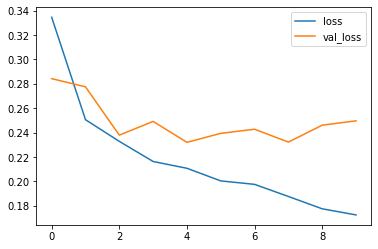

In [108]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

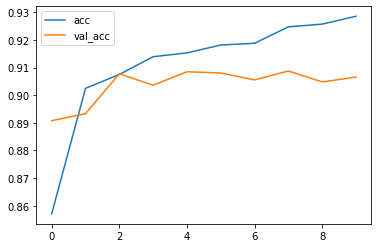

In [109]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [110]:
#predict on test data

p_test = model.predict(data_test)
full_p_test = p_test #save the probablilities for later analysis
p_test = np.round(p_test) # rounding changes the probility to 0 or 1
p_test = p_test.flatten()

p_test = p_test.astype(np.int)



In [111]:
#show accuracy
misclassified_idx = np.where(p_test != Ytest)[0]
masc_idx = np.where(p_test ==  0)[0]
fem_idx = np.where(p_test == 1)[0]
test_acc = np.mean(Ytest == p_test)
print("Misclassified ", len(misclassified_idx), " out of ", len(p_test), 'nouns for a misclassification rate of ', len(misclassified_idx)/len(p_test))


Misclassified  634  out of  6784 nouns for a misclassification rate of  0.09345518867924528


In [112]:
#display  misclassified
gender = ['m', 'f']
for i in range(len(misclassified_idx)):
 print(i,":Noun: ", df_test.iloc[misclassified_idx[i]]," - Predicted: ", gender[p_test[misclassified_idx[i]]], " / Actual: ", gender[Ytest[misclassified_idx[i]]],' / PROB: ', full_p_test[misclassified_idx[i]])
    

0 :Noun:  calice  - Predicted:  f  / Actual:  m  / PROB:  [0.5258519]
1 :Noun:  épiderme  - Predicted:  f  / Actual:  m  / PROB:  [0.5833925]
2 :Noun:  milady  - Predicted:  m  / Actual:  f  / PROB:  [0.09630289]
3 :Noun:  coolie  - Predicted:  f  / Actual:  m  / PROB:  [0.9460412]
4 :Noun:  cimeterre  - Predicted:  f  / Actual:  m  / PROB:  [0.5720843]
5 :Noun:  chasse-d'eau  - Predicted:  m  / Actual:  f  / PROB:  [0.3080155]
6 :Noun:  apologue  - Predicted:  f  / Actual:  m  / PROB:  [0.590548]
7 :Noun:  one-step  - Predicted:  f  / Actual:  m  / PROB:  [0.7616763]
8 :Noun:  stéréotype  - Predicted:  f  / Actual:  m  / PROB:  [0.7963298]
9 :Noun:  abbaye  - Predicted:  m  / Actual:  f  / PROB:  [0.21677908]
10 :Noun:  encéphale  - Predicted:  f  / Actual:  m  / PROB:  [0.68785363]
11 :Noun:  patache  - Predicted:  m  / Actual:  f  / PROB:  [0.47522148]
12 :Noun:  sportswear  - Predicted:  f  / Actual:  m  / PROB:  [0.67356837]
13 :Noun:  cuti  - Predicted:  m  / Actual:  f  / PROB: 